In [12]:
import ldfi_py.pilp
import ldfi_py.psat
from parsing import ZipkinParser
import sys, re, os
from IPython.display import Image
from huawei_local import *


Different possible labeling functions:

In [13]:
# put this into a library later, or borrow tuan's function

def get_label_3(data):
    svcarr = data[9].split(":")[1].split("-")
    svcarr.pop()
    return "-".join(svcarr)

def get_label_2(data):
    return data[9].split(":")[1]

def get_label_1(data):
    return data[9]

def get_label(data):
    return get_label_1(data)


# Parse the file and pick a bucket

In [18]:
trace_file = '1st_half_jan_26'
buckets = get_all_buckets(trace_file)

keys = buckets.keys()
keys.sort()

for key in keys:
    print "KEY " + key + " -- " + str(len(buckets[key]))
    
        

key = "http://api-gateway:8080/product/product/buy/34211223411"

print "KEYo " +  key
print "has " + str(key in buckets)
print "type " + str(type(buckets))

val = buckets[key]

print "UH " + str(val)

    

OK
KEY 10.154.72.17:30000_images_Huawei%20Air.pngGET__images_Huawei Air.png_* -- 1 <type 'str'>
KEY 10.154.72.17:30000_js_acmeair-common.jsGET__js_acmeair-common.js_* -- 1 <type 'str'>
KEY 127.0.0.1:8081_atswebsite_websiteGET__atswebsite_website -- 359 <type 'str'>
KEY api-gateway:8080_product_product_buy_34211223411POST__error -- 300 <type 'str'>
KEY api-gateway:8080_product_product_buy_34211223411POST__product_product_* -- 202 <type 'str'>
KEY api-gateway:8080_product_product_searchAllGET__error -- 1556 <type 'str'>
KEY api-gateway:8080_product_product_searchAllGET__product_product_* -- 1406 <type 'str'>
KEY api-gateway:8080_user_user_loginPOST__error -- 30 <type 'str'>
KEY api-gateway:8080_user_user_loginPOST__user_user_* -- 170 <type 'str'>
KEY http://10.154.72.17:30000/images/Huawei%20Air.png -- 1 <type 'str'>
KEY http://10.154.72.17:30000/js/acmeair-common.js -- 1 <type 'str'>
KEY http://127.0.0.1:8081/atswebsite/website -- 349 <type 'str'>
KEY http://api-gateway:8080/product/pro

# Hse a rich label (service, instance, method)
# plot it

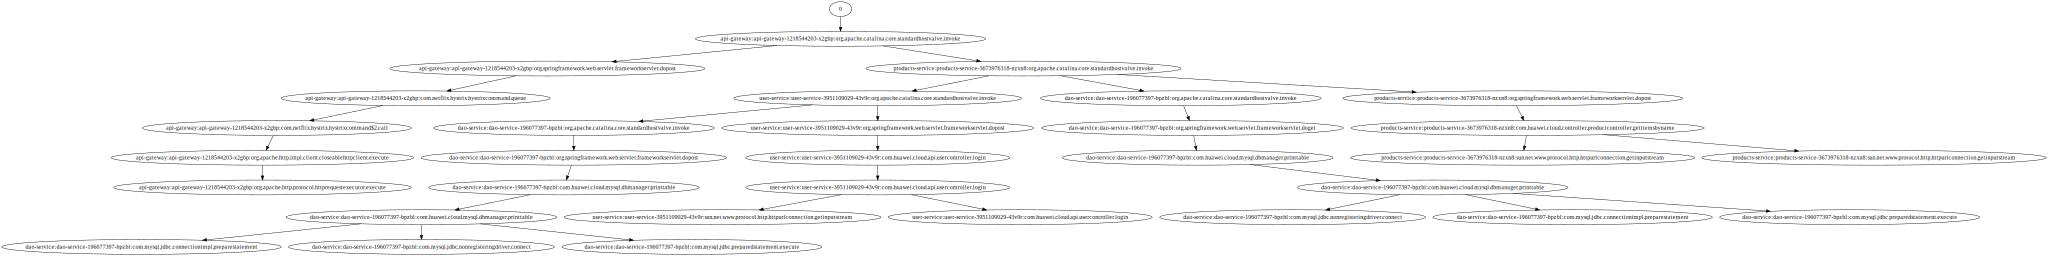

In [4]:
list(buckets[key])[1].to_dot(get_label_1)

# convert to a boolean formula, normalize to CNF, and solve using ILP

In [14]:
formula = get_formula(buckets[key], get_label_1)
cnf = CNFFormula(formula)
s = ldfi_py.pilp.Solver(cnf)
crs = s.solutions()


# Initial fault suggestions:

In [15]:
crs.next()

[user_service:user_service_3951109029_43v9r:org.springframework.web.servlet.frameworkservlet.dopost,
 api_gateway:api_gateway_985328082_ph6p9:com.netflix.hystrix.hystrixcommand$2.call,
 api_gateway:api_gateway_985328082_m4rll:com.netflix.hystrix.hystrixcommand$2.call,
 api_gateway:api_gateway_985328082_f2jc1:com.netflix.hystrix.hystrixcommand$2.call,
 api_gateway:api_gateway_4025834462_lphbg:com.netflix.hystrix.hystrixcommand$2.call,
 dao_service:dao_service_196077397_4h984:com.huawei.cloud.mysql.dbmanager.printtable,
 dao_service:dao_service_196077397_x8zch:org.springframework.web.servlet.frameworkservlet.doget]

Unsurprisingly, when we use the richest label, nodes occur less often across different graphs, and hence solutions (combinations of faults that affect *all* graphs) are larger.  The suggestion above indicates that we should inject faults simultaneously at 7 distinct call sites...

# use a less rich label (service, instance)

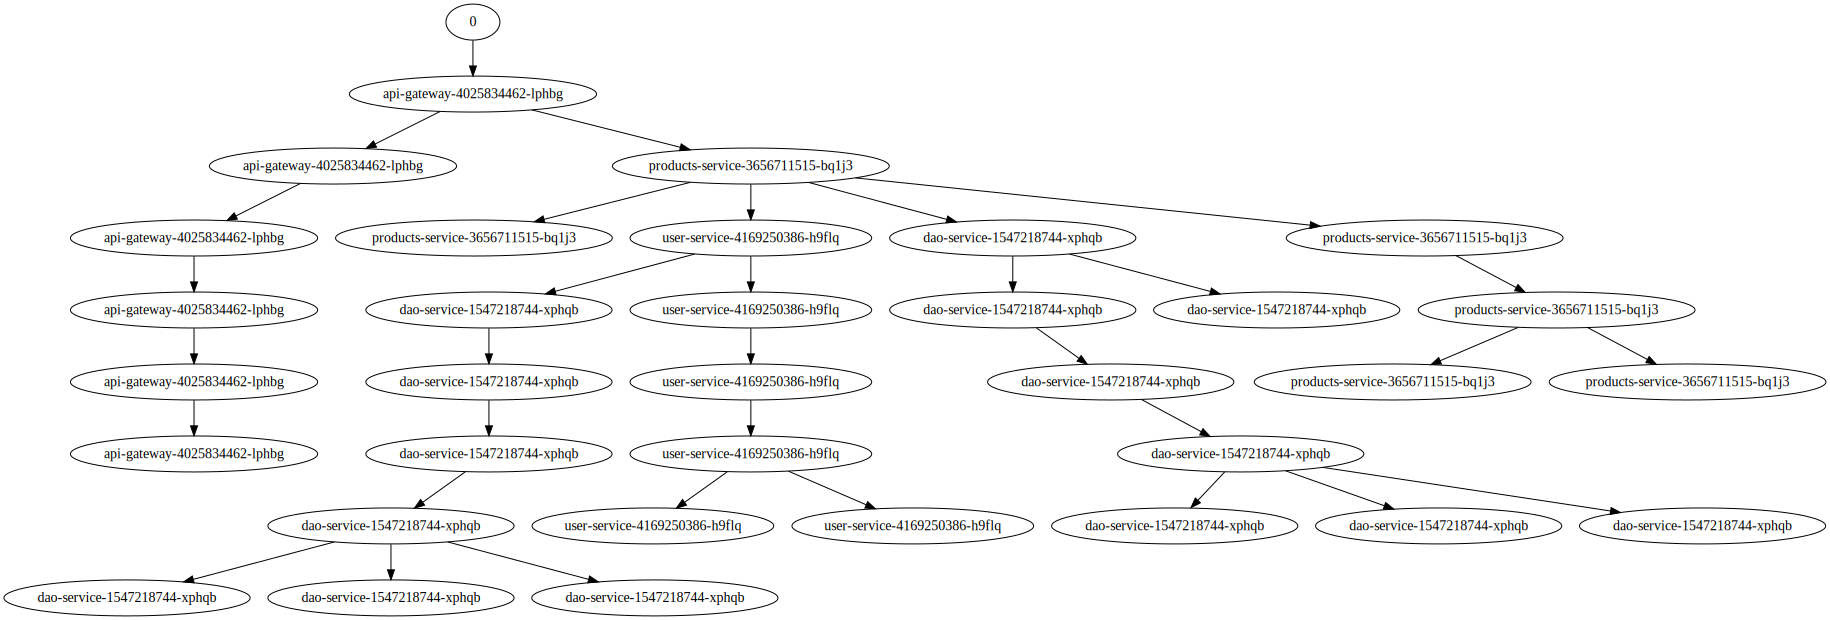

In [16]:
list(buckets[key])[1].to_dot(get_label_2)

In [18]:
formula = get_formula(buckets[key], get_label_2)
cnf = CNFFormula(formula)
s = ldfi_py.pilp.Solver(cnf)
crs = s.solutions()
crs.next()

[api_gateway_985328082_f2jc1,
 user_service_3951109029_43v9r,
 user_service_4169250386_h9flq,
 api_gateway_985328082_ph6p9,
 user_service_3951109029_6cptx,
 user_service_3951109029_vz4xn,
 api_gateway_985328082_m4rll]

Seven faults again.  This indicates to me that while including the method call in the label gives us interesting additional information that could be used to inject faults at a fine grain, it is the instance identifiers that cause nodes to differ most across graphs.

# truncate the instance id (service, truncated_instance_id)

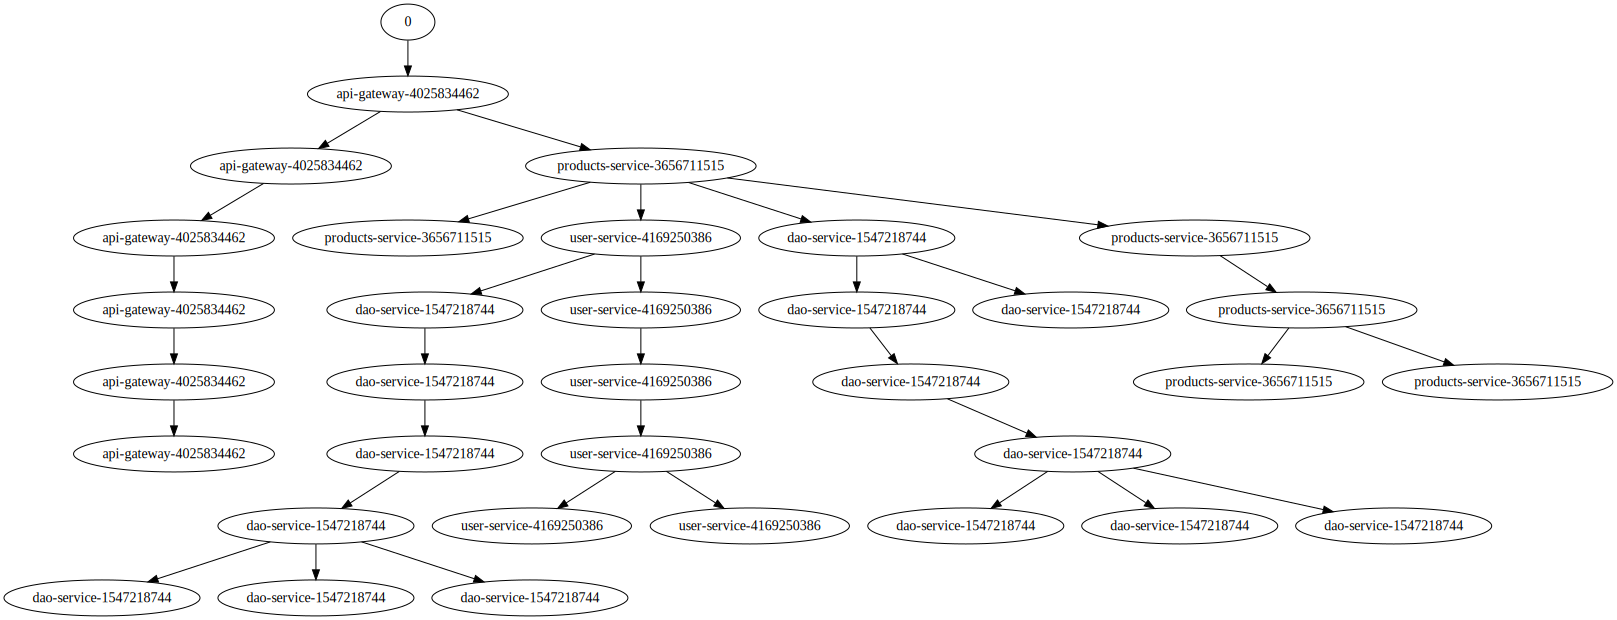

In [19]:
list(buckets[key])[1].to_dot(get_label_3)

In [20]:
formula = get_formula(buckets[key], get_label_3)
cnf = CNFFormula(formula)
s = ldfi_py.pilp.Solver(cnf)
crs = s.solutions()
crs.next()

[user_service_4169250386, user_service_3951109029, api_gateway_985328082]

Now we are down to a more reasonable set of three concurrent faults to inject.